In [1]:
# Importing the required packages 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta, datetime
import random
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/auditfinding/audit_dataset.csv


In [2]:
# Uploading the data to pandas frame
df = pd.read_csv("/kaggle/input/auditfinding/audit_dataset.csv")

In [3]:
#check the first five records
df.head()

,Audit_ID,Department,Audit_Finding,Risk_Level,Audit_Date
0,1,Operations,Non-compliance,Medium,2022-03-23
1,2,Finance,Fraudulent Activity,Medium,2022-09-05
2,3,HR,Non-compliance,High,2022-09-03
3,4,Operations,Non-compliance,Medium,2022-03-27
4,5,IT,Control Weakness,High,2022-11-05


In [4]:
#check the last five records
df.tail()

,Audit_ID,Department,Audit_Finding,Risk_Level,Audit_Date
9995,9996,HR,Non-compliance,Low,2022-12-19
9996,9997,IT,Control Weakness,High,2022-04-26
9997,9998,Finance,Non-compliance,Medium,2022-07-18
9998,9999,HR,Fraudulent Activity,Low,2022-06-18
9999,10000,Finance,Control Weakness,Low,2022-12-22


In [5]:
# checking the number of records available
df.shape

(10000, 5)

There are 10000 records across five variables: Audit_ID, Department, Audit_fiding, Risk_Level, Audit_Date

In [6]:
# Descriptive statistics
descriptive_stats = df.describe()
descriptive_stats

,Audit_ID
count,10000.00000
mean,5000.50000
std,2886.89568
min,1.00000
25%,2500.75000
50%,5000.50000
75%,7500.25000
max,10000.00000


In [7]:
# Key findings
finding_counts = df['Audit_Finding'].value_counts()
finding_counts 


Fraudulent Activity    3444
Control Weakness       3295
Non-compliance         3261
Name: Audit_Finding, dtype: int64

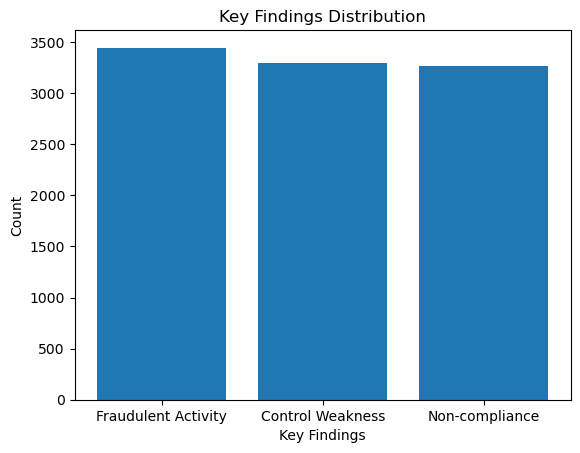

In [8]:
# Plot the key findings distribution
plt.bar(finding_counts .index, finding_counts .values)
plt.xlabel('Key Findings')
plt.ylabel('Count')
plt.title('Key Findings Distribution')
plt.show()

In [9]:
risk_levels = df['Risk_Level'].value_counts()
risk_levels

High      3377
Medium    3317
Low       3306
Name: Risk_Level, dtype: int64

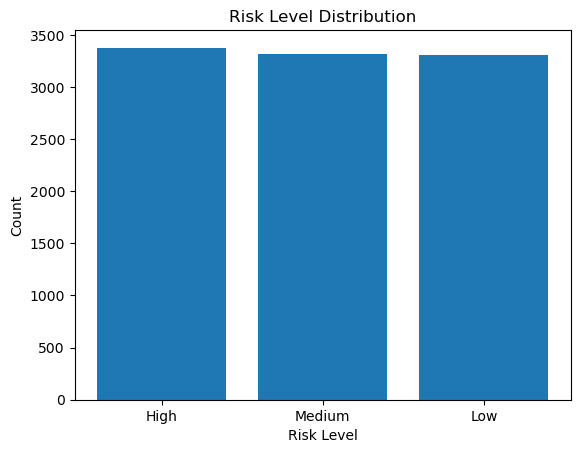

In [10]:
# Plot the risk level distribution
plt.bar(risk_levels.index, risk_levels.values)
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.title('Risk Level Distribution')
plt.show()

In [11]:
depts = df['Department'].value_counts()
depts

Operations    2010
HR            2007
Finance       1998
IT            1993
Marketing     1992
Name: Department, dtype: int64

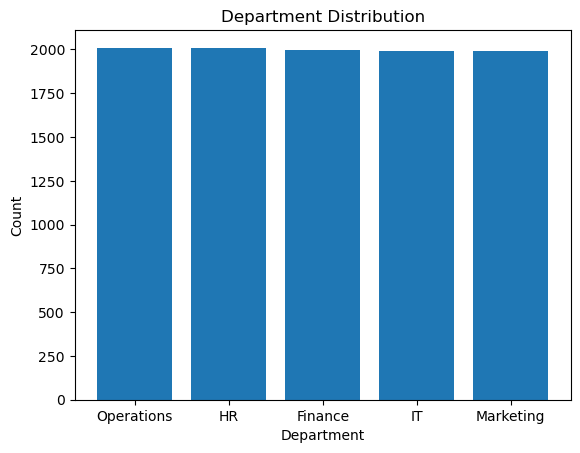

In [12]:
# Plot the department distribution
plt.bar(depts.index, depts.values)
plt.xlabel('Department')
plt.ylabel('Count')
plt.title('Department Distribution')
plt.show()

In [13]:
# Trending the data by months since the number of years is 1
# Convert the 'Audit_Date' column to datetime if it's not already in datetime format
df['Audit_Date'] = pd.to_datetime(df['Audit_Date'])

In [14]:
# Group the data by month and count the occurrences of each month
monthly_counts = df.groupby(df['Audit_Date'].dt.to_period('M')).size()

In [15]:
# Convert the period index to strings
monthly_counts.index = monthly_counts.index.astype(str)

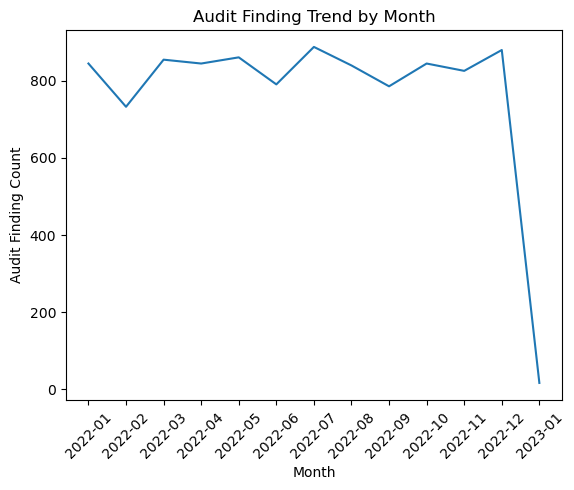

In [16]:
# Plot the data trend by months
plt.plot(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.ylabel('Audit Finding Count')
plt.title('Audit Finding Trend by Month')
plt.xticks(rotation=45)
plt.show()

In [17]:

# Convert the 'Audit_Date' column to datetime if it's not already in datetime format
df['Audit_Date'] = pd.to_datetime(df['Audit_Date'])

In [18]:
# Group the data by month and risk level, and count the occurrences of each combination
monthly_risk_counts = df.groupby([df['Audit_Date'].dt.to_period('M'), 'Risk_Level']).size().unstack()

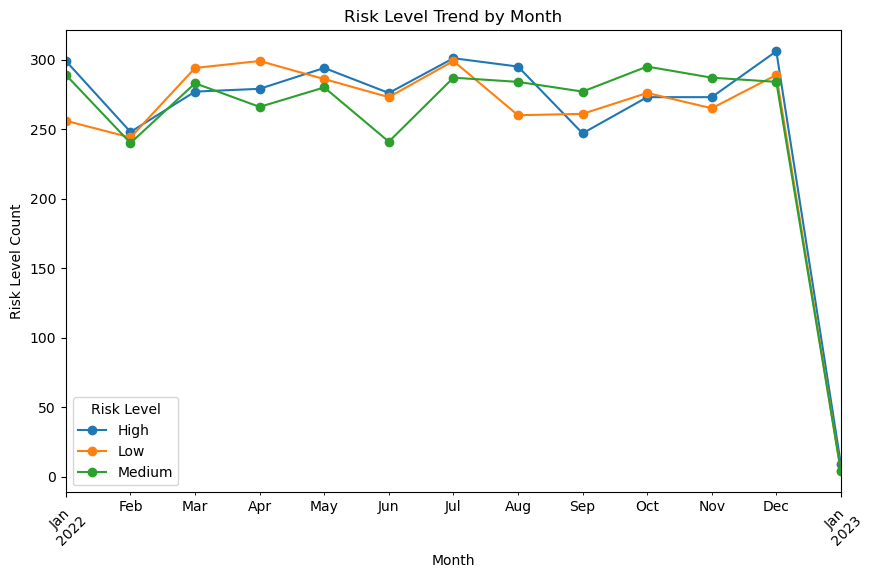

In [19]:
# Plot the data trend of risk levels by months
monthly_risk_counts.plot(marker='o', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Risk Level Count')
plt.title('Risk Level Trend by Month')
plt.xticks(rotation=45)
plt.legend(title='Risk Level')
plt.show()

In [20]:
# Group the data by month and audit finding, and count the occurrences of each combination
monthly_findings_counts = df.groupby([df['Audit_Date'].dt.to_period('M'), 'Audit_Finding']).size().unstack()

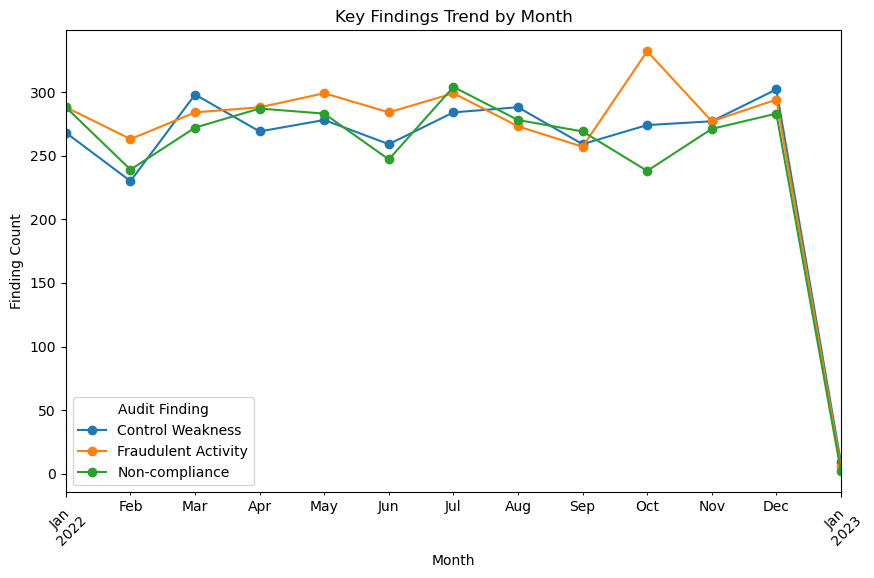

In [21]:
# Plot the data trend of key findings by months
monthly_findings_counts.plot(marker='o', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Finding Count')
plt.title('Key Findings Trend by Month')
plt.xticks(rotation=45)
plt.legend(title='Audit Finding')
plt.show()

In [22]:
# Group the data by month and department, and count the occurrences of each combination
monthly_department_counts = df.groupby([df['Audit_Date'].dt.to_period('M'), 'Department']).size().unstack()

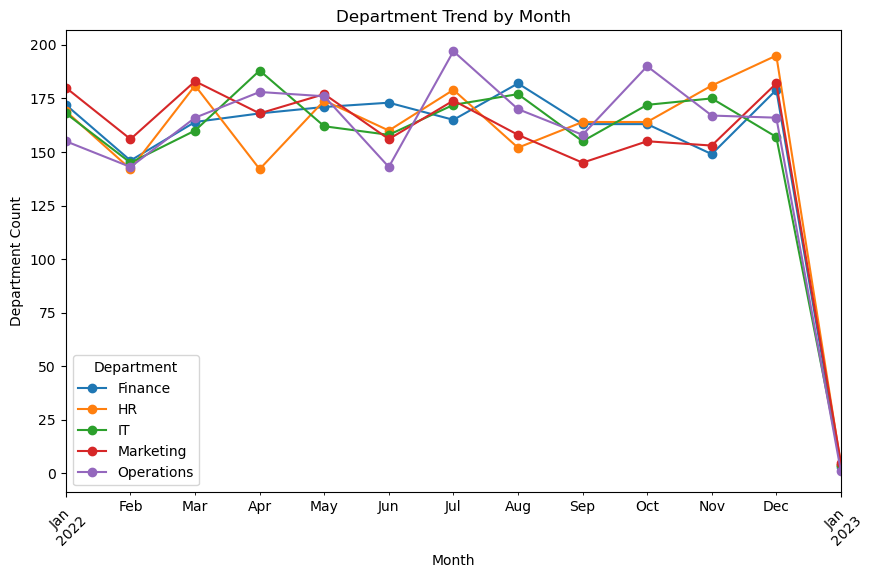

In [23]:
# Plot the data trend of departments by months
monthly_department_counts.plot(marker='o', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Department Count')
plt.title('Department Trend by Month')
plt.xticks(rotation=45)
plt.legend(title='Department')
plt.show()


In [24]:
# Create a new DataFrame with the counts of key findings, risk levels, and departments
counts_df = pd.DataFrame({
    'Key Findings': df['Audit_Finding'].value_counts(),
    'Risk Levels': df['Risk_Level'].value_counts(),
    'Departments': df['Department'].value_counts()
})

# **Identification of Patterns and Anomalies**

In [25]:
# Identification of Patterns and Anomalies

# Feature selection
features = ['Department', 'Risk_Level']
X = pd.get_dummies(df[features])

In [26]:
# Clustering using K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
# Anomaly detection using Isolation Forest
clf = IsolationForest(contamination=0.1, random_state=42)
df['Is_Anomaly'] = clf.fit_predict(X)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


# Prediction and Risk Assessment

In [28]:
# Selecting the features for analysis
features = ['Audit_ID', 'Cluster']

In [29]:
# Extracting the feature values
X = df[features].values

In [30]:
# Clustering using K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
# Anomaly detection using Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
df['Is_Anomaly'] = isolation_forest.fit_predict(X)

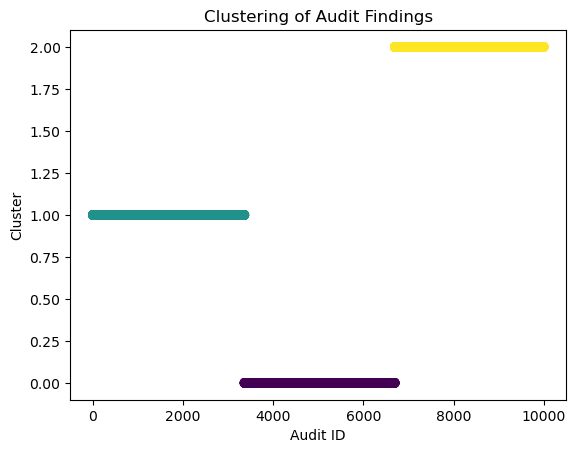

In [32]:
# Plotting the clusters
plt.scatter(df['Audit_ID'], df['Cluster'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Audit ID')
plt.ylabel('Cluster')
plt.title('Clustering of Audit Findings')
plt.show()

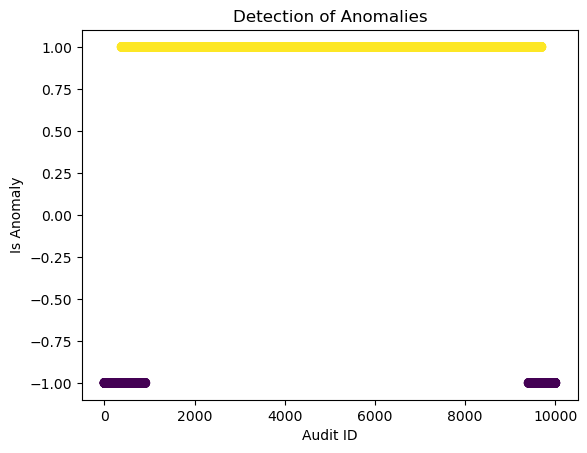

In [33]:
# Plotting the anomalies
plt.scatter(df['Audit_ID'], df['Is_Anomaly'], c=df['Is_Anomaly'], cmap='viridis')
plt.xlabel('Audit ID')
plt.ylabel('Is Anomaly')
plt.title('Detection of Anomalies')
plt.show()

In [34]:
# Feature selection for prediction
prediction_features = ['Department', 'Risk_Level']
X_pred = pd.get_dummies(df[prediction_features])
y_pred = df['Audit_Finding']

In [35]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)

In [36]:
# Training a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [37]:
# Predicting audit findings
y_pred = clf.predict(X_test)

In [38]:
# Classification report
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

   Control Weakness       0.33      0.34      0.33       627
Fraudulent Activity       0.35      0.47      0.40       697
     Non-compliance       0.32      0.20      0.24       676

           accuracy                           0.34      2000
          macro avg       0.33      0.34      0.33      2000
       weighted avg       0.33      0.34      0.33      2000

